In [1]:
% matplotlib inline

import numpy as np, nibabel as nib, seaborn as sns, pandas as pd
import plotting_lighterbg as plot
import glob, os, time, datetime
import random
from scipy.sparse.csgraph import connected_components
from matplotlib import pyplot as plt
from scipy.stats import spearmanr
from joblib import Parallel, delayed

sns.set_style('white')

/home/raid3/oligschlager/anaconda2/envs/distconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# variables
hemi = 'lh'
netw_names = ['medial wall','Vp','Vc','SMa','SMb','DAa','DAb','VA',
               'S','L','L','Cc','Ca','Cb','Dd','Dc','Da','Db']
# paths
fs_dir = '/afs/cbs.mpg.de/projects/mar004_lsd-lemon-preproc/freesurfer'
netw_dir = '/scr/liberia1/data/Yeo_JNeurophysiol11_FreeSurfer/fsaverage5/label' 
afs_dir = '/afs/cbs.mpg.de/projects/mar005_lsd-lemon-surf'

In [3]:
# load data
netw_labels = nib.freesurfer.io.read_annot('%s/%s.Yeo2011_17Networks_N1000.annot' % (netw_dir, hemi))[0]
coords = nib.freesurfer.io.read_geometry('%s/fsaverage5/surf/%s.pial' % (fs_dir, hemi))[0]
coords_infl = nib.freesurfer.io.read_geometry('%s/fsaverage5/surf/%s.inflated' % (fs_dir, hemi))[0]
faces = nib.freesurfer.io.read_geometry('%s/fsaverage5/surf/%s.pial' % (fs_dir, hemi))[1]
cort = np.sort(nib.freesurfer.read_label('%s/fsaverage5/label/%s.cortex.label' % (fs_dir, hemi)))
sulc = nib.freesurfer.read_morph_data('%s/fsaverage5/surf/%s.sulc' % (fs_dir, hemi))

dist_matrix = np.load('%s/documents/data_grouplevel/lsd_geoDist_groupmean_%s.npy' % (afs_dir, hemi))
dist_cort = dist_matrix[cort,:][:,cort]

df = pd.read_pickle(max(glob.iglob('%s/documents/data_grouplevel/lsd_data_grouplevel_20*.pkl' % afs_dir), 
                        key=os.path.getctime))
df = df[df['sample'] == 'LSD subjects']
renorm = dist_matrix.max()
df['mean distance (geodesic) - group mean'] = df['mean distance (geodesic) - group mean'] * renorm
orig_distconnect = np.array(df['mean distance (geodesic) - group mean'][(df['threshold'] == '98') 
                                                     & (df['hemisphere'] == hemi)])

## Creating spatially continuous patches from network parcellation

In [5]:
# adjacency matrix with ones where two nodes share an edge, i.e. are part of a triangle
edges_matrix = np.zeros((10242, 10242))
for f in faces:
    edges_matrix[f[0], f[1]] = 1
    edges_matrix[f[1], f[2]] = 1
    edges_matrix[f[0], f[2]] = 1
    edges_matrix[f[1], f[0]] = 1
    edges_matrix[f[2], f[1]] = 1
    edges_matrix[f[2], f[0]] = 1
     
# if there are distributed patches, there will be more than one connected component in the edges matrix per network
patch_labels = np.zeros((10242))
count = 0
for network in range(18):   # still includes medial wall
    patches = connected_components(edges_matrix[np.ix_(np.where(netw_labels == network)[0], 
                                                       np.where(netw_labels == network)[0])], directed=False)
    patch_labels[netw_labels == network] = patches[1] + count
    count += patches[0]
        
# sizes of original patches
sizes_orig = np.array([(patch_labels == i).sum() for i in range(count)])

# drop medial wall (888) and tiny patches (for comparison later)
kept_patches = np.where((sizes_orig > 10) & (sizes_orig != 888))[0]
        

## Connectivity model based on original network topography and mean distance to connected areas on model connectivity (with comparison to original group-level map)



In [19]:
conn_matrix = np.zeros((10242,10242))

for network in range(18):
    conn_matrix[np.ix_(np.where(netw_labels == network)[0], np.where(netw_labels == network)[0])] = 1
    

kept_patches_labels = np.array([n for n, patch in enumerate(patch_labels) if patch in kept_patches])
del_patches_mask = np.array([False if patch in kept_patches else True for patch in patch_labels])

conn_matrix[np.ix_(del_patches_mask, del_patches_mask)] = 0
np.fill_diagonal(conn_matrix, 1)

model_distconnect = [dist_matrix[node][conn_matrix[node] == 1].mean() for node in range(10242)]

print np.corrcoef(orig_distconnect[cort], np.array(model_distconnect)[cort])

[[ 1.          0.73517008]
 [ 0.73517008  1.        ]]


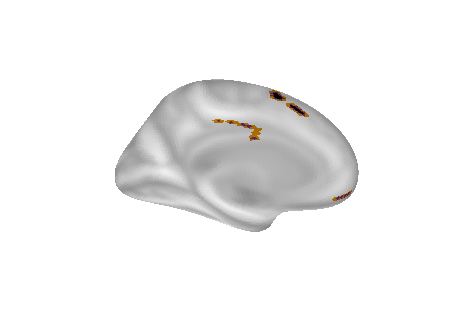

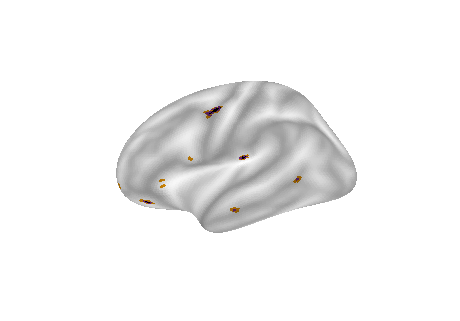

In [8]:
# patches that were not included due to their small size

test = [1.5 if node in kept_patches_labels else 0 for node in range(10242)]

for azim in [0, 180]:
    img1 = plot.plot_surf_stat_map(coords_infl, faces, np.array(test), azim=azim, cmap='CMRmap', 
                              mask=cort, bg_map=sulc, bg_on_stat=True)

first model, then original data


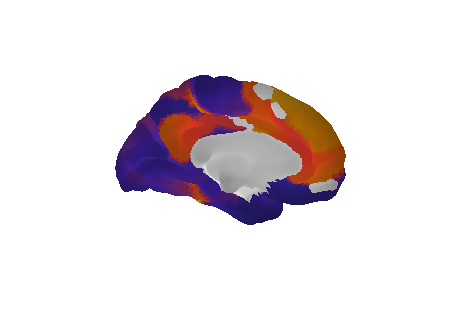

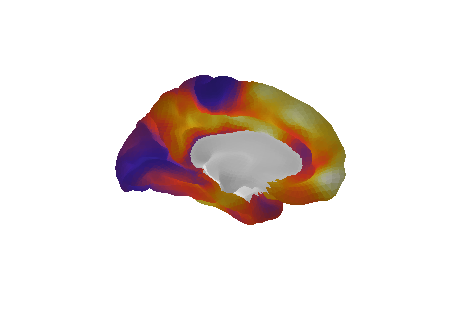

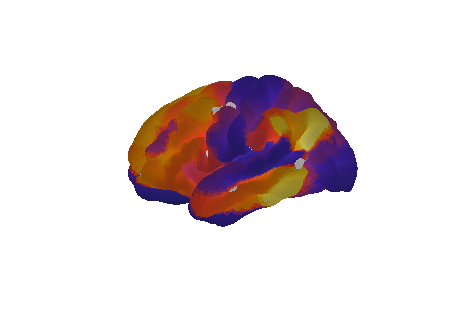

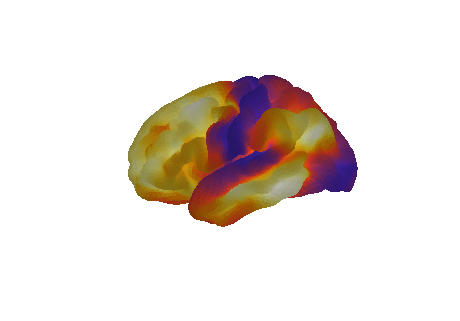

In [49]:
# comparing model connectivity based on original network topogrphay with original connectivity

print 'first model, then original data'
for azim in [0, 180]:
    img1 = plot.plot_surf_stat_map(coords, faces, np.array(model_distconnect), azim=azim, cmap='CMRmap', 
                              mask=kept_patches_labels, bg_map=sulc, bg_on_stat=True)
    img2 = plot.plot_surf_stat_map(coords, faces, orig_distconnect, azim=azim, cmap='CMRmap', 
                              mask=cort, bg_map=sulc, bg_on_stat=True)
    img1.savefig('/scr/hunte1/sabine/distconnect/figures/images/suppl_4_model_distconnect_%s.png' 
                %azim, dpi=600)

## Correlation between model distconnect and distance from primary when using the centroids of primary patches instead of depth of sulcus (for fair comparison to randomized data)

In [40]:
# correlation between distance from primary and distconnect
# but using the model distconnect value
# and using network centroids as reference instead of sulcal depth

primary_networks = [1, 2, 3, 4]
primary_centroids = list()

for i in primary_networks:
    # don't know how to make this shorter
    idx_small = np.argmin(dist_matrix[np.ix_((netw_labels == i),
                                             (netw_labels == i))].mean(axis=0))
    temp_small = [1 if x==idx_small else 0 for x in range((netw_labels == i).sum())]
    temp_big = np.zeros((10242))
    temp_big[netw_labels == i] = temp_small
    primary_centroids.append(np.argmax(temp_big))
    
# distance to closest primary centroid
zone_labels = np.argsort(dist_matrix[primary_centroids], axis=0)[0, :]
dist_closest_primary = np.zeros((10242))
for n, i in enumerate(primary_centroids):
    dist_closest_primary[zone_labels == n] = dist_matrix[i, zone_labels == n]

# assessing correlation only within 80cm vicinity as used for original data
# spearmanr(dist_closest_primary[cort], np.array(model_distconnect)[cort])
dist_closest_primary_cort = dist_closest_primary[cort]
model_distconnect_cort = np.array(model_distconnect)[cort]

r = spearmanr(dist_closest_primary_cort[dist_closest_primary_cort <= 80], 
          model_distconnect_cort[dist_closest_primary_cort <= 80])

## random parcellation / patches, and according distconnect map and correlation between distconnect map and dist from new primary location

In [12]:
def iteration(cort, kept_patches, dist_cort, sizes_orig, netw_labels, patch_labels, dist_matrix):

    iter_count = 0
    primary_networks = [1, 2, 3, 4]

    #for iter in range(iters):
    while iter_count < 1:

        # random Voronoi parcellation with same number of patches
        rand_points = random.sample(range(cort.shape[0]), kept_patches.shape[0])
        rand_patch_labels = np.argsort(dist_cort[rand_points], axis=0)[0, :]

        # sizes of new random patches
        sizes = [(rand_patch_labels == i).sum() for i in range(len(rand_points))]


        # sort original and random patches by size
        # corresponding network membership in same order for size-matching btw random and original patches

        kept_patches_bysize = kept_patches[np.argsort(sizes_orig[kept_patches])]

        netwmembership_by_patchsize = np.array([netw_labels[patch_labels == p][0] 
                                                for n,p in enumerate(kept_patches_bysize)])

        rand_patches_bysize = np.argsort(sizes)


        # keep random patch arrangement only if size distribution is comparable to original patches
        sizes_corr = np.corrcoef(np.array(sizes)[rand_patches_bysize],
                                 sizes_orig[kept_patches_bysize])

        if any(abs(diff) > 100 for diff in (np.sort(np.array(sizes)) - np.sort(sizes_orig[kept_patches]))):
            continue
        if sizes_corr[0,1] < .95:
            continue

        # reconstruct model connectivity and distconnect on shuffled patches
        rand_conn_matrix_cort = np.zeros((cort.shape[0],cort.shape[0]))
        rand_conn_matrix = np.zeros((10242,10242))

        for network in range(18):

            new_netw_nodes = list()
            for patch in rand_patches_bysize[netwmembership_by_patchsize == network]:
                new_netw_nodes.extend(np.where(rand_patch_labels == patch)[0].tolist())
            new_netw_nodes.sort()

            rand_conn_matrix_cort[np.ix_(new_netw_nodes, new_netw_nodes)] = 1

        rand_conn_matrix[np.ix_(cort,cort)] = rand_conn_matrix_cort

        rand_model_distconnect = [dist_matrix[node][rand_conn_matrix[node] == 1].mean() 
                                  if node in cort else 0 for node in range(10242)]


        #spatial_correlations.append(np.corrcoef(rand_model_distconnect, orig_distconnect)[0,1])


        # correlation betweeen distconnect and dist from primary

        rand_primary_centroids = list()

        for n in primary_networks:

            assigned_primary_patch = rand_patches_bysize[netwmembership_by_patchsize == n][0]
            rand_primary_centroids.append(rand_points[assigned_primary_patch])

        if any(node not in cort for node in rand_primary_centroids):
            continue

        # distance to closest random primary centroid
        zone_labels = np.argsort(dist_matrix[rand_primary_centroids], axis=0)[0, :]
        dist_closest_rand_primary = np.zeros((10242))

        for n, i in enumerate(rand_primary_centroids):
            dist_closest_rand_primary[zone_labels == n] = dist_matrix[i, zone_labels == n]


        #corr = spearmanr(dist_closest_rand_primary[cort], 
        #                 np.array(rand_model_distconnect)[cort])[0]

        dist_closest_rand_primary_cort = dist_closest_rand_primary[cort]
        rand_model_distconnect_cort = np.array(rand_model_distconnect)[cort]

        corr = spearmanr(dist_closest_rand_primary_cort[dist_closest_rand_primary_cort <= 80], 
                         rand_model_distconnect_cort[dist_closest_rand_primary_cort <= 80])[0]

        if np.isnan(corr):
            continue

        iter_count += 1
        return corr

        


In [24]:
results = Parallel(n_jobs = 50)(delayed(iteration)(cort, 
                                                  kept_patches, 
                                                  dist_cort, 
                                                  sizes_orig, 
                                                  netw_labels, 
                                                  patch_labels, 
                                                  dist_matrix)
                               for i in range(1000))

In [26]:
np.save('/afs/cbs.mpg.de/projects/mar005_lsd-lemon-surf/results/permutations/iterations_1000.npy',
        np.array(results))

# Results

## Correlation between dist-to-connected-areas and dist from primary
### histgram shows correlations from 1000 permutations
### correlation for model FC based on original network arrangement was .59
### correlation in original data was .7

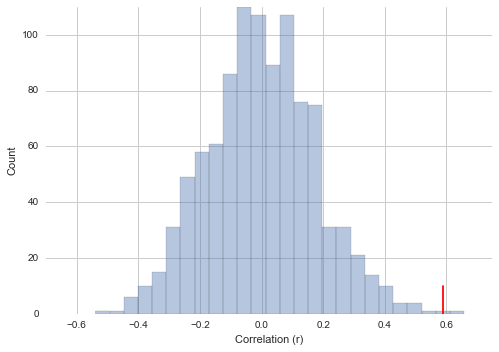

In [54]:
sns.set(style="whitegrid")

f, ax = plt.subplots()

sns.distplot(results, kde=False)
plt.plot((.59, .59), (0, 10), 'red')

plt.xlim(-.7,.75)
plt.ylim(0,110)
plt.xlabel('Correlation (r)')
plt.ylabel('Count')
sns.despine(left=True, bottom=True)

f.savefig('/scr/hunte1/sabine/distconnect/figures/images/suppl_4_permutations.png', dpi=600)

In [48]:
# original correlation between dist-to-connected-areas and dist from primary
r

0.59213659322421253

In [47]:
# p-value

print r > np.percentile(np.array(results), 99.8)
print r > np.percentile(np.array(results), 99.9)

True
False


In [39]:
# p-value < 0.002
0.2 / 100

0.002